# Text Data Explanation Benchmarking: Emotion Multiclass Classification

This notebook demonstrates how to use the benchmark utility to benchmark the performance of an explainer for text data. In this demo, we showcase explanation performance for partition explainer on an Emotion Multiclass Classification model. The metrics used to evaluate are "keep positive" and "keep negative". The masker used is Text Masker.

The new benchmark utility uses the new API with MaskedModel as wrapper around user-imported model and evaluates masked values of inputs.

In [1]:
import nlp
import numpy as np
import pandas as pd
import scipy as sp
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

import shap
import shap.benchmark as benchmark

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_colwidth", None)

### Load Data and Model

In [2]:
train, test = nlp.load_dataset("emotion", split=["train", "test"])

data = {"text": train["text"], "emotion": train["label"]}

data = pd.DataFrame(data)

Using custom data configuration default


In [3]:
tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion")

### Class Label Mapping

In [4]:
# set mapping between label and id
id2label = model.config.id2label
label2id = model.config.label2id
labels = sorted(label2id, key=label2id.get)

### Define Score Function

In [5]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding="max_length", max_length=128, truncation=True) for v in x])
    attention_mask = (tv != 0).type(torch.int64)
    outputs = model(tv, attention_mask=attention_mask)[0].detach().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

### Create Explainer Object

In [6]:
explainer = shap.Explainer(f, tokenizer, output_names=labels)

explainers.Partition is still in an alpha state, so use with caution...


### Run SHAP Explanation

In [7]:
shap_values = explainer(data["text"][0:20])

Partition explainer:   5%|█▋                               | 1/20 [00:00<?, ?it/s]

Partition explainer:  15%|███▊                     | 3/20 [00:58<04:17, 15.12s/it]

Partition explainer:  20%|█████                    | 4/20 [01:28<05:12, 19.51s/it]

Partition explainer:  25%|██████▎                  | 5/20 [01:55<05:23, 21.59s/it]

Partition explainer:  30%|███████▌                 | 6/20 [02:20<05:17, 22.71s/it]

Partition explainer:  35%|████████▊                | 7/20 [02:45<05:03, 23.36s/it]

Partition explainer:  40%|██████████               | 8/20 [03:10<04:46, 23.86s/it]

Partition explainer:  45%|███████████▎             | 9/20 [03:35<04:27, 24.30s/it]

Partition explainer:  50%|████████████            | 10/20 [04:06<04:24, 26.43s/it]

Partition explainer:  55%|█████████████▏          | 11/20 [04:46<04:34, 30.47s/it]

Partition explainer:  60%|██████████████▍         | 12/20 [05:22<04:15, 31.91s/it]

Partition explainer:  65%|███████████████▌        | 13/20 [05:57<03:49, 32.84s/it]

Partition explainer:  70%|████████████████▊       | 14/20 [06:35<03:27, 34.52s/it]

Partition explainer:  75%|██████████████████      | 15/20 [07:15<03:01, 36.24s/it]

Partition explainer:  80%|███████████████████▏    | 16/20 [07:55<02:29, 37.32s/it]

Partition explainer:  85%|████████████████████▍   | 17/20 [08:34<01:53, 37.69s/it]

Partition explainer:  90%|█████████████████████▌  | 18/20 [09:06<01:12, 36.05s/it]

Partition explainer:  95%|██████████████████████▊ | 19/20 [09:42<00:36, 36.04s/it]

Partition explainer: 100%|████████████████████████| 20/20 [10:24<00:00, 37.84s/it]

Partition explainer: 21it [10:52, 31.06s/it]                                      


### Define Metrics (Sort Order & Perturbation Method)

In [8]:
sort_order = "positive"
perturbation = "keep"

### Benchmark Explainer

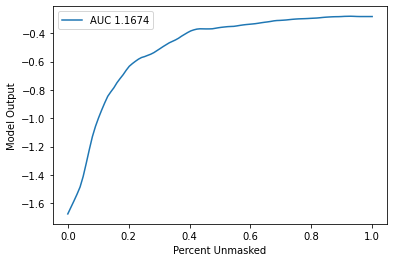

In [9]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, sort_order, perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values, data["text"][0:20])
sequential_perturbation.plot(xs, ys, auc)

In [10]:
sort_order = "negative"
perturbation = "keep"

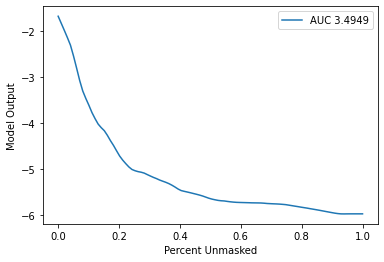

In [11]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, sort_order, perturbation
)
xs, ys, auc = sequential_perturbation.model_score(shap_values, data["text"][0:20])
sequential_perturbation.plot(xs, ys, auc)